In [1]:
import os
import sys
pdir = os.path.dirname(os.getcwd())
sys.path.append(pdir)

import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

import utils
from simpleview_pytorch import SimpleView

In [2]:
cloud = utils.pc_from_txt("../data/treesXYZ/alt01_24.txt")
cloud = utils.center_and_scale(cloud)

(<Figure size 2160x360 with 6 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

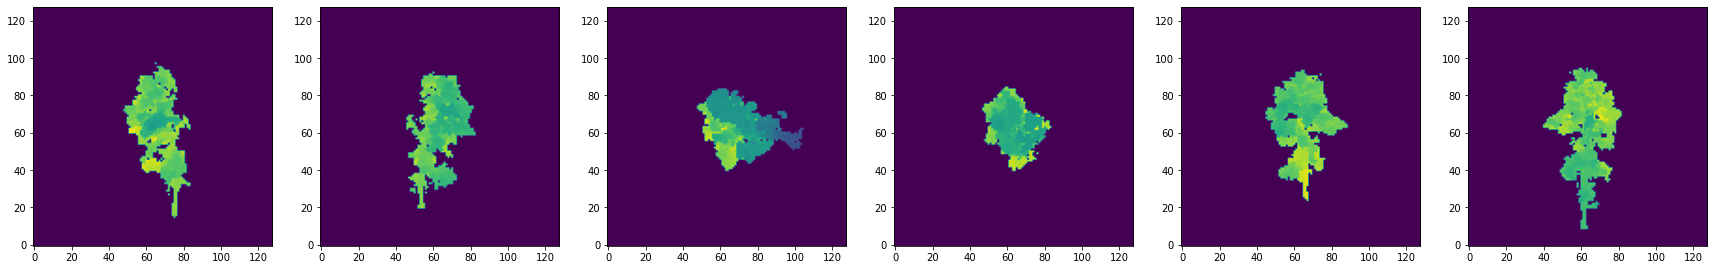

In [3]:
sample_images = utils.get_depth_images_from_cloud(cloud)
utils.plot_depth_images(sample_images)

In [4]:
%%time
metadata_file = "../data/treesXYZ/meta/META.csv"
data_dir = "../data/treesXYZ/"
trees_dataset = utils.TreeSpeciesDataset(data_dir=data_dir, metadata_file=metadata_file)

100%|██████████| 2485/2485 [20:53:52<00:00, 30.27s/it]    

CPU times: user 22h 17min 42s, sys: 22min 38s, total: 22h 40min 20s
Wall time: 20h 53min 52s


In [6]:
torch.save(trees_dataset, 'trees.pt')

In [7]:
x = torch.load('trees.pt')

(<Figure size 2160x360 with 6 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

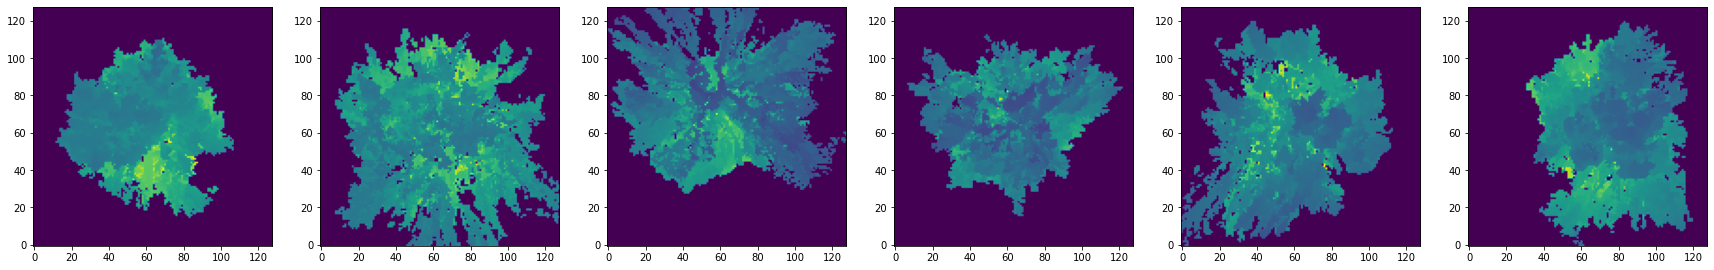

In [12]:
utils.plot_depth_images(x.depth_images[899])